# **5_Modeling (BERT)**

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [ ]:
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab

In [ ]:
m = Mecab()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import sklearn as sk

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/NLP_news_topic_classification/preprocessed_train.csv")
test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/NLP_news_topic_classification/preprocessed_test.csv")

In [ ]:
# 전처리 과정에서 불필요한 컬럼 생겨서 삭제
train = train.drop(columns=["Unnamed: 0"])
test = test.drop(columns=["Unnamed: 0"])

## **BERT**  
references:  
https://heung-bae-lee.github.io/2020/01/16/NLP_01/  
https://ebbnflow.tistory.com/151
  
구글에서 개발한 NLP 사전 훈련 기술, 모든 자연어처리 분야에서 좋은 성능을 내는 범용 Language Model (앙상블 모델보다 더 좋은 성능)  
  
**사전 훈련 언어모델**, LSTM, CNN 등등처럼 과제(개체명 인식, 텍스트 분류)를 시행하는 모델 X  
특정 과제를 수행하기 위한 모델의 성능은 Embedding이 큰 영향을 미침  
**Embedding 과정**에서 **BERT**를 사용, **특정 과제를 하기 전 사전 훈련 Embedding을 통해 특정과제의 성능을 더 좋게**  

**< Embedding >**:  
사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자 형태인 vector로 바꾼 결과 혹은 그 과정  
  
역할)
1. 단어/문장 간 관련도 계산 : 단어들 사이의 유사도를 계산
2. 의미적/문법적 정보 함축 : 벡터이기에 사칙연산 가능, 벡터간 덧셈/뺄셈을 통해 단어들 사이의 의미적, 문법적 관계 도출 가능 
3. 전이학습 : 품질이 좋은 임베딩은 다른 딥러닝 모델에서도 쓸 수 있음

종류)  
- 통계기반 -> 뉴럴 네트워크 기반
: TF-IDF Matrix, Word-Context Matrix -> Neural Network 
- 단어수준 -> **문장 수준**  
: 단어의 문맥적 의미를 함축 but 동음이의어 분간 어렵 (NPLM, Word2Vec, GloVe)   
: **Sequence 전체의 문맥적 의미를 함축, 전이학습 효과 좋음, 동음이의어도 분간 가능 (BERT, GPT)**
- Rule based -> End to End -> **Pre-training/fine-tuning**  
: 머신러닝처럼 사람이 언어학적 지식 활용해서 Feature 직접 뽑음 (Rule based)  
: 데이터를 넣어주면 사람의 개입없이 모델 스스로 처음부터 끝까지 이해 (Sequence-to-Sequence) (End to End)  
: **ELMO, GPT, BERT (Pre-training/fine-tuning)**   

< 텍스트 분류모델 과정 >  
- Bert 사용X 일반 모델과정 : 데이터 -> LSTM, CNN 등 머신러닝 모델 -> 분류  
- **BERT 사용 모델링** : 대량 Corpus -> Bert -> 분류를 원하는 데이터 -> LSTM, CNN등의 머신러닝 모델 -> 분류 
: 대량 Corpus로 BERT 언어모델 적용, BERT 언어모델 출력에 추가적인 모델(RNN, CNN 등 머신러닝 모델)을 쌓아 원하는 과제 수행  
  
**< BERT 내부 과정 >**  
1. **Input** : Token Embedding + Segment Embedding + Position Embedding
- **Token Embedding** : CLS(Special Classification Token)는 모든 문장의 첫 토큰으로 삽입, classification task에서만 사용, SEP(Special Seperator Token)을 사용하여 첫번째 문장과 두번째 문장을 구별, 각 문장 끝에 삽입  
- **Segment Embedding** : CLS, SEP에 더해서 앞뒤 문장을 더욱 쉽게 구별할 수 있도록 도와줌줌
- **Position Embedding** : 각 토큰의 위치를 알려주는 임베딩

-> 세가지 임베딩을 합치고 이에 layer 정규화와 dropout을 적용하여 input으로 사용  
  
2. **Pre-training** : 훈련시킬 데이터를 모두 인코딩했으므로 사전훈련시킴, 기존 방법은 문장 왼쪽에서 오른쪽으로 학습하여 다음 단어 예측하거나 예측할 단어의 좌우문맥을 고려하여 예측  but BERT : MLM + NSP (2가지 unsupervised 방법)
- **MLM(Masked Language Model)** : 문장에서 단어 중 일부를 Mask 토큰으로 바꾼 뒤, 가려진 단어를 예측하도록 학습
- **NSP(Next Sentence Prediction)** : 두 문장이 주어졌을 때, 두 문장의 순서 예측, 두 문장의 연관을 맞추는 학습을 진행 (Q&A task 성능향상에 영향향)
  
3. **Transfer Learning** : 학습된 언어모델을 전이학습시켜 실제 NLP 과제를 수행하는 과정, 실질적 성능이 관찰되는 부분
- BERT 언어모델에 NLP Task를 위한 추가적인 모델을 쌓는 부분  
  
**< BERT 한계점 >**  
일반 NLP 모델에서는 잘 작동, 하지만 bio, science, finance 등 특정 분야의 언어모델에 사용하려면 잘 적용이 되지 않음, 사용 단어들이 다르고 언어의 특성이 다르기 때문, 특정 분야의 특성을 수집할 수 있는 언어데이터를 수집하고 언어모델 학습을 추가적으로 진행 후 특정분야에 BERT 적용할 것것


## **BERT 모델**   
references : https://hwiyong.tistory.com/392  

- 양방향성 포함, 문맥을 더 자연스럽게 파악 가능  
- text classification, question & answering, machine translation, 사람처럼 대화하기 에 쓰임, but language representation(단어, 문장, 언어를 어떻게 표현할까에 관한 고민)  
- pre-training이 가능한 모델 : 기존 모델은 처음부터 학습시켜야함 but 전이 학습 가능 (ELMO, BERT, GPT 등)
- transformer 구조에서 encoder 부분만 사용, encoder 학습시킨 후 특정 task의 fine-tuning을 활용하여 결과 얻음음  
cf) 기존 모델 : encoder + decoder, GPT : decoder 부분 사용해서 원하는 task의 결과 얻음  
  
references : https://dacon.io/competitions/official/235747/codeshare/2905?page=1&dtype=recent

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 82.7 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.1 MB/s eta 0:00:00


In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import BertModel, TFBertModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

In [30]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.xticks([0, 1, 2], labels=["1st", "2nd", "3rd"])
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
#random seed 고정
tf.random.set_seed(21)
np.random.seed(21)

In [ ]:
# parameter 설정
BATCH_SIZE = 200                    # batch size 
NUM_EPOCHS = 3                      # 반복 수 -> 돌아가는데 너무 오래 걸림
VALID_SPLIT = 0.2                   # train:valid = 8:2
MAX_LEN = 44                        # Max Length - RNN, LSTM 모델 돌렸을 때는 13으로 나왔는데 단어 기준이었나? 
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

### BertTokenizer  
references : https://hyen4110.tistory.com/89
  
**Tokenizer** : corpus를 token으로 나누는 작업
  
**BertTokenizer의 차별점** 
- WordPiece Tokenizer
- BPE(Byte Pair Encoding) : OOV(Out of Vocabulary)의 문제점 완화
- Subword Segmatation (서브워드 분리) : 더 작은 단위의 의미있는 여러 서브단어들로 이루어진 하나의 단어 (ex: birthplace = birth + place) 인 경우 서브워드로 분리해서 인코딩 및 임베딩  
  
**BertTokenizer의 Input & Output**  
**Input** : 텍스트 list (ex: ["제목", "제목", "제목"])  
**Output** : 토큰화 결과 dictionary  
["input_ids" : tensor([[], [], []]),  
 "token_type_ids": tensor([[], [], []]),  
 "attention_mask" : tensor([[], [], []])} 
   
 - **input_ids** : 각 토큰에 대한 정수 인코딩
 - **token_type_ids** (=segment_ids) : pretraining 단계에서 Next Sentence Prediction 을 위해 존재  
ex : 0 - sequence A, 1 - sequence B : 두 sequence 구별
 - **attention_mask** : 0 - 단어 토큰, 1 - 패딩 토큰 (optional 따라서 파라미터로 정함함)

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

In [ ]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True,      # Add '[CLS]' (각 문장의 처음에 들어가는 토큰, classification task 일 때만 사용) and '[SEP]' (첫번째 두번째 문장 사이를 구분하게 해주는 토큰, 문장의 끝부분에 들어가는 토큰큰) 
        max_length = MAX_LEN,           # Pad & truncate all sentences
        pad_to_max_length = True,       # MAX_LEN 보다 짧은 애들은 패딩시벼줌
        return_attention_mask = True    # Construct attn. masks.  (문장에서 임의로 Mask로 단어를 가리고 그 단어를 예측하게 하는 학습을 할 것인지지)
        
    )
    
    input_id = encoded_dict['input_ids']              # 각 토큰에 대한 정수 인코딩
    attention_mask = encoded_dict['attention_mask']   # And its attention mask (simply differentiates padding from non-padding), input할 때 mask랑 다른 mask인가, 단어토큰 - 0, 패딩토큰 - 1로 구별
    token_type_id = encoded_dict['token_type_ids']    # differentiate two sentences, token_type_ids는 sequence 2개를 구별
    
    return input_id, attention_mask, token_type_id

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train["title"], train["topic_idx"]), total=len(train)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_news_input_ids = np.array(input_ids, dtype=int)
train_news_attention_masks = np.array(attention_masks, dtype=int)
train_news_type_ids = np.array(token_type_ids, dtype=int)
train_news_inputs = (train_news_input_ids, train_news_attention_masks, train_news_type_ids)  # train_news_inputs에 각 토큰에 대한 정수 인코딩, 패딩여부 구분, 두 sequence 구별을 input으로 넣어줌 = BertTokenizer Output -> 모델 input (X값)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) # 레이블 tokenizing 리스트 (실제 y값 토크나이징 ?)

print("# sents: {}, # labels: {}".format(len(train_news_input_ids), len(train_data_labels)))

100%|██████████| 53403/53403 [00:27<00:00, 1922.13it/s]


# sents: 53403, # labels: 53403


In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)                                                                # dropout : 과적합 방지 위해 파라미터로 주어진 확률만큼 뉴런 제거
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),       # 라벨 개수만큼 Dense층 FC layer 구현
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        # outputs : sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)
        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased', dir_path='bert_ckpt', num_class=7)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
optimizer = tf.keras.optimizers.Adam(3e-5)                                  # optimizer - Adam
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)      # loss - SparseCategoricalCrossEntropy, Sparse는 라벨이 정수일 때 사용, 저번 RNN에서는 CategoricalCrossEntropy만 사용(-> 라벨이 원핫인코딩되어 있을 때는 Categorical X Sparse)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')             # metric - 평가기준 정확도
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])         # 모델(optimizer, loss, metrics)

In [ ]:
model_name = "tf2_bert_naver_train"

# overfitting을 막기 위해 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001) - 정확도 0.0001 이상 안오르면 종료
# patience: no improvment epochs (patience = 1) - 1번 이상 improve(?)가 없으면 종료

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_news_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

data_out/KOR/tf2_bert_naver_train -- Folder create complete 

Epoch 1/3
214/214 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.7831
Epoch 1: val_accuracy improved from -inf to 0.87426, saving model to data_out/KOR/tf2_bert_naver_train/weights.h5
214/214 [==============================] - 463s 2s/step - loss: 0.6299 - accuracy: 0.7831 - val_loss: 0.3888 - val_accuracy: 0.8743
Epoch 2/3
214/214 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.8669
Epoch 2: val_accuracy improved from 0.87426 to 0.89842, saving model to data_out/KOR/tf2_bert_naver_train/weights.h5
214/214 [==============================] - 408s 2s/step - loss: 0.3903 - accuracy: 0.8669 - val_loss: 0.2987 - val_accuracy: 0.8984
Epoch 3/3
214/214 [==============================] - ETA: 0s - loss: 0.3169 - accuracy: 0.8877
Epoch 3: val_accuracy improved from 0.89842 to 0.90544, saving model to data_out/KOR/tf2_bert_naver_train/weights.h5
214/214 [==============================] 

런타임 일반으로 할 때는 epoch 한번 돌 때 하루 종일 돌아서 epoch 수 3 -> 2 로, batch size 100 -> 200으로 변경했는데도 RAM이 꽉찼다 이랬는데 런타임 유형 gpu로 변경하니깐 빨리 돌아가서 epoch 3번으로 함

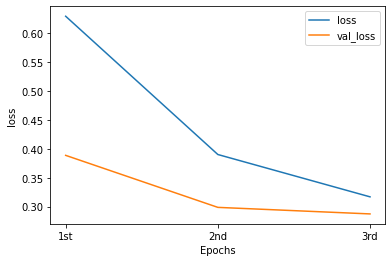

In [31]:
plot_graphs(history, "loss")

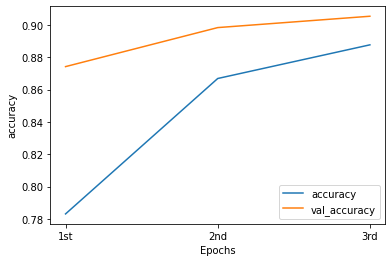

In [32]:
plot_graphs(history, "accuracy")